In [77]:
import pandas as pd
import tensorflow as tf
import numpy as np
keras = tf.keras
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import random
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import matplotlib.pyplot as plt
import warnings

plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')

In [78]:
np.random.seed(4)

In [79]:
!ls data/clean/

Alito.csv     Ginsburg.csv  Kagan.csv     Roberts.csv   Thomas.csv
Breyer.csv    Gorsuch.csv   Kavanaugh.csv Sotomayor.csv


In [80]:
# Modular class that loads data for the given justice and evaluates using the model that is added. 
# Evaluates accuracy and f-1 score
# balances using undersampling by default

class JusticeModel:
    
    def __init__(self, justice, model=None):
        
        self.justice = justice.capitalize()
        self.load_justice()
        self.model = model
        self.tfidf = TfidfVectorizer()
        
    def load_justice(self):
        '''
        Loads the appropriate dataframe for the justice. 
        Splits the dataframe into a training dataset and testing dataset.
        '''
        fpath = 'data/clean/%s.csv' % self.justice
        df = pd.read_csv(fpath)
        df['cleanText'] = df['cleanText'].fillna(' ')
        self.data = df

    def add_model(self, model):
        self.model = model
        
    def fit(self, balance_method='undersampling'):
        '''
        Vectorizes training data, compiles the model, and trains it.
        '''
        
        if self.model == None:
            print('Add Model First')
            return
        
        X = self.data['cleanText'].to_numpy()
        y = self.data['vote'].to_numpy()
       
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)
        X_train, y_train = self.balance_train_data(X_train, y_train, method=balance_method)
    
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
                      
        self.train_vectors = self.tfidf.fit_transform(X_train)
        self.model.fit(self.train_vectors, y_train)
        
    def predict(self):
        self.test_vectors = self.tfidf.transform(self.X_test)
        self.y_preds = self.model.predict(self.test_vectors)
        
    def evaluate(self):
        acc = accuracy_score(self.y_test, self.y_preds)
        f1 = f1_score(self.y_test, self.y_preds)
        print('Accuracy: %.3f' % acc)
        print('F1 Score: %.3f' % f1)
        return acc, f1

    def balance_train_data(self, X, y, method=None):
        uniq, cts = np.unique(y, return_counts=True)

        if method == None:
            return X, y

        elif method == 'undersampling':
            train_amt = cts[0] if cts[0] < cts[1] else cts[1]

            replace_0 = False
            replace_1 = False

        elif method == 'oversampling':    
            train_amt = cts[0] if cts[0] > cts[1] else cts[1]

            replace_0 = False if cts[0] > cts[1] else True
            replace_1 = True if cts[0] > cts[1] else False

        else:
            print('Incorrect balance method')
            return

        c_0_index = np.argwhere(y == 0).flatten()
        c_1_index = np.argwhere(y == 1).flatten()

        train_0 = np.random.choice(c_0_index, train_amt, replace=replace_0)
        train_1 = np.random.choice(c_1_index, train_amt, replace=replace_1)

        train = list(train_0)
        train.extend(list(train_1))

        np.random.shuffle(train)

        return X[train], y[train]

In [128]:
def balance_train_data(X, y, method=None):
    uniq, cts = np.unique(y, return_counts=True)
    
    if method == None:
        return X, y
    
    elif method == 'undersampling':
        train_amt = cts[0] if cts[0] < cts[1] else cts[1]
        
        replace_0 = False
        replace_1 = False

    elif method == 'oversampling':    
        train_amt = cts[0] if cts[0] > cts[1] else cts[1]
        
        replace_0 = False if cts[0] > cts[1] else True
        replace_1 = True if cts[0] > cts[1] else False
        
    else:
        print('Incorrect balance method')
        return
    
    c_0_index = np.argwhere(y == 0).flatten()
    c_1_index = np.argwhere(y == 1).flatten()
    
    train_0 = np.random.choice(c_0_index, train_amt, replace=replace_0)
    train_1 = np.random.choice(c_1_index, train_amt, replace=replace_1)
    
    train = list(train_0)
    train.extend(list(train_1))

    np.random.shuffle(train)

    return X[train], y[train]

In [138]:
def plot_cross_val(models, data, ax, sampling_method):

    X = data['cleanText'].to_numpy()
    y = data['vote'].to_numpy()

    kf = KFold(n_splits=10, shuffle=True)

    precisions = [[], [], []] 
    recalls = [[], [], []]
    
    for train, test in kf.split(X):
        X_test, y_test = X[test], y[test]
        X_train, y_train = balance_train_data(X[train], y[train], method=sampling_method)

        tfidf = TfidfVectorizer()
        train_vectors = tfidf.fit_transform(X_train)
        test_vectors = tfidf.transform(X_test)  
        for i, model in enumerate(models):
            model.fit(train_vectors, y_train)
            y_pred = model.predict(test_vectors)
            
            precisions[i].append(precision_score(y_test, y_pred))
            recalls[i].append(recall_score(y_test, y_pred))
    
    x = range(0, 10)
    colormap = {0 : 'r',
                1 : 'b',
                2 : 'g'}
    
    for i in range(len(models)):
        ax.plot(x, precisions[i], c=colormap[i], 
                linewidth=1, linestyle='-',
                label='%s Precision' % models[i].__class__.__name__)
        ax.plot(x, recalls[i], c=colormap[i], 
                linewidth=1, linestyle='--',
                label='%s Recall' % models[i].__class__.__name__)

            


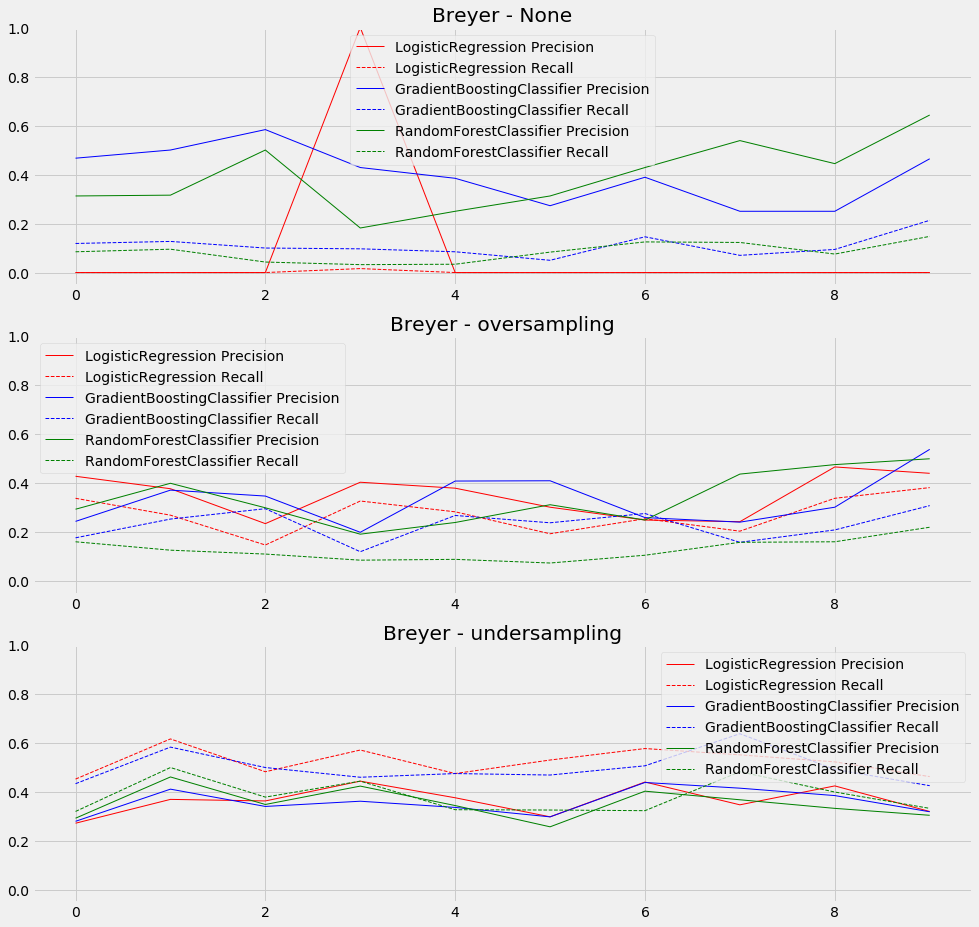

In [143]:
fig, ax = plt.subplots(3, 1, figsize=(15, 15))

methods = [None, 'oversampling', 'undersampling']

for i, method in enumerate(methods):
    data = pd.read_csv('data/clean/Breyer.csv')
    data['cleanText'] = data['cleanText'].fillna(' ')
    models = [LogisticRegression(), GradientBoostingClassifier(), RandomForestClassifier()]
    plot_cross_val(models, data, ax[i], method)
    ax[i].set_title('Breyer - %s' % (str(method)))
    ax[i].legend()
    ax[i].set_ylim(-0.05, 1)
    
    